In [1]:
using Unitful:mm,
    m,inch,Pa,K,Hz,kHz,GPa, Pressure, Temperature, Frequency,ustrip, MPa
using Plots

In [2]:
# Parameters to the Johnson Cook flow stress model
abstract type PlasticModel end
struct MaterialModel
    E_y::Pressure 
    σ_y::Pressure
    plastic::PlasticModel
end
struct JohnsonCookParams <: PlasticModel
    ∂ϵ_∂t_0::Frequency
    T_room::Temperature
    T_m::Temperature
    T_test::Temperature
    A::Pressure
    B::Pressure
    C
    n
    m
end
struct KNParams <: PlasticModel
    K::Pressure
    N::Real
end

#Parameters to the Cowper Symonds yeild stress model
struct CowperSymondsParams <: PlasticModel
    A::Pressure
    B::Pressure
    C::Frequency
    p
    P
end

#Parameter to the Ludwik yeild stress model
struct LudwikParams <: PlasticModel
    A::Pressure
    B::Pressure
    C
end
units = Pa

function yieldStress(plasticModel::PlasticModel, materialModel::MaterialModel, ∂ϵ_∂t::Frequency)::Pressure
   materialModel.σ_y 
    end
function yieldStress(csp::CowperSymondsParams, materialModel::MaterialModel, ∂ϵ_∂t::Frequency)::Pressure
   materialModel.σ_y*(1+(∂ϵ_∂t/csp.C)^(1/csp.P))
end

#Function that calculates the stress of the material after the yeild point
#CowperSymonds
function plasticStress(σ_y::Pressure, ϵ_plastic::Real, ∂ϵ_∂t::Frequency, materialModel::MaterialModel, csp::CowperSymondsParams):: Pressure
    σ_y+csp.B*ϵ_plastic^csp.p*(1+(∂ϵ_∂t/csp.C)^(1/csp.P)) |>units
end
#Ludwik
function plasticStress(σ_y::Pressure, ϵ_plastic::Real, ∂ϵ_∂t::Frequency, materialModel::MaterialModel, lwp::LudwikParams)::Pressure
    σ_y + lwp.B*(ϵ_plastic)^lwp.C |> units #Ludwik's work hardening equation
    end
#KN
function plasticStress(σ_y::Pressure, ϵ_plastic::Real, ∂ϵ_∂t::Frequency, materialModel::MaterialModel, knp::KNParams)::Pressure
    knp.K*(ϵ_plastic)^knp.N |> units
end
#JohnsonCook
function plasticStress(σ_y::Pressure, ϵ_plastic::Real, ∂ϵ_∂t::Frequency, materialModel::MaterialModel,jcp::JohnsonCookParams)::Pressure
    ((σ_y+jcp.B*(ϵ_plastic)^jcp.n)*(1+jcp.C*log(∂ϵ_∂t/jcp.∂ϵ_∂t_0))
        *(1-((jcp.T_test-jcp.T_room)/(jcp.T_m-jcp.T_room))^jcp.m)) |> units
end

#Fuction that gives the flow stress using the effective strain
function stress(ϵ, ∂ϵ_∂t::Frequency, materialModel::MaterialModel)::Pressure
    σ_y = yieldStress(materialModel.plastic, materialModel, ∂ϵ_∂t)
    if ϵ < σ_y/materialModel.E_y
        return ϵ*materialModel.E_y
    else
        ϵ_plastic = ϵ - σ_y/materialModel.E_y
        return plasticStress(σ_y, ϵ_plastic, ∂ϵ_∂t, materialModel, materialModel.plastic)
    end
end


#= 
σ_y-reference yield sress
E - Material's elastic modulus
E_t - Tangent modulus
E_y - Youngs Modulus
β - Hardening coefficient
ϵ^p - effective plastic strain
δϵ_δt - strain rate
δϵ_δt_0 - reference strain rate
C & P - strain-rate params of Cowper Symonds model
B,n,c & m - strain- and and strain-rate-dependent parameters of the Johnson-Cook material model
ϵ - strain
K - strength coefficient of the Hollomon equation
N - Strain hardening exponent of the Hollomon equation
k - strenght coefficient of the Ludwik equation
n - Strain hardening exponent of the Ludwik equation
=#

stress (generic function with 1 method)

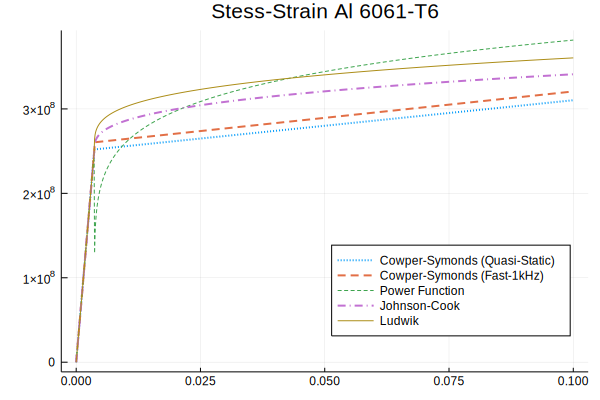

In [3]:
#For Al 6061-T6
#Below are the CowperSymonds Constants
E_t = 600e6Pa
E = 72e9Pa
β = 1
#The above three parameters are used to calulate B. Sometimes they are given, sometimes not.
r = 208.8e6Pa #K-value for the cs model
A = 252e6Pa
B = β*(E_t*E)/(E-E_t)
#B = 451e6Pa
C = 25000Hz
n = 0.28
p = 1
P = 0.95
E_y = 68.9e9Pa
σ_y = A #Yeild Strength for the Ludwik equaiton
∂ϵ_∂t = 6.7e-4Hz
k=640e6Pa
csp = CowperSymondsParams(A,B,C,p,P)
csp_matmod = MaterialModel(E_y,σ_y,csp)
ϵs = 0:0.0001:0.1
plot(ϵs,map(ϵ -> stress(ϵ,∂ϵ_∂t,csp_matmod)|> ustrip, ϵs)
    ,linestyle = :dot
    ,linewidth = 2
    ,label="Cowper-Symonds (Quasi-Static)"
    ,title="Stess-Strain Al 6061-T6"
    ,legend = :bottomright)
∂ϵ_∂t = 1kHz
plot!(ϵs,map(ϵ -> stress(ϵ,∂ϵ_∂t,csp_matmod)|> ustrip, ϵs)
    ,linestyle = :auto
    ,linewidth = 2
    ,label="Cowper-Symonds (Fast-1kHz)")
∂ϵ_∂t = 1Hz

#Below are the KN Constants
r = 530e6Pa
n = 0.14048
knp = KNParams(r,n)
knp_matmod = MaterialModel(E_y,σ_y,knp)
plot!(ϵs,map(ϵ -> stress(ϵ,∂ϵ_∂t,knp_matmod)|> ustrip, ϵs),linestyle = :dash,linewidth = 1,label="Power Function")

#Below are the JohnsonCook Constants (Source 1)
∂ϵ_∂t_0 = 1Hz
T_room = 294.26K
T_m = 925.37K
T_test = 300K
#A = 289.6e6Pa
σ_y = A
B = 203.4e6Pa
c = 0.011
n = 0.35
h = 1.34 #This is the exponent on temperature for JohnsonCook
jcp = JohnsonCookParams(∂ϵ_∂t_0,T_room,T_m,T_test,A,B,c,n,h)
jcp_matmod = MaterialModel(E_y,σ_y,jcp)
plot!(ϵs,map(ϵ -> stress(ϵ,∂ϵ_∂t,jcp_matmod)|> ustrip, ϵs),linestyle = :dashdot,linewidth = 2,label="Johnson-Cook")

#Below are the Ludwik Constants
#A = 257.3e6Pa
σ_y = A
B = 208.8e6Pa
C = 0.28
lwp = LudwikParams(A,B,C)
lwp_matmod = MaterialModel(E_y,σ_y,lwp)
plot!(ϵs,map(ϵ -> stress(ϵ,∂ϵ_∂t,lwp_matmod)|> ustrip, ϵs),label="Ludwik")

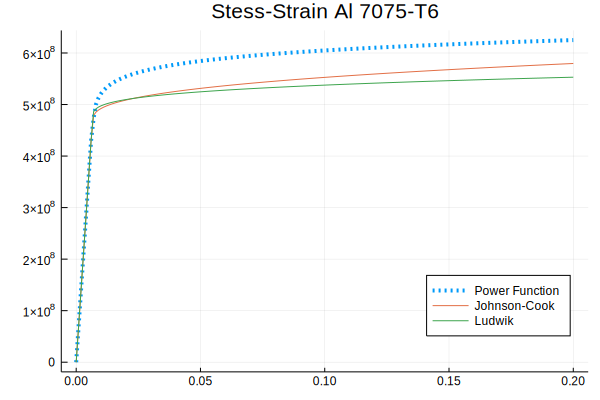

In [9]:
#For Al 7075-T6

#Below are the KN Constants
ϵs = 0:0.001:0.2
∂ϵ_∂t = 1Hz #There's no information regarding the strain rate for both the KN and JC models, so I choose this value
r = 673e6Pa
n = 0.045
E_y = 71.7e9Pa
knp = KNParams(r,n)
knp_matmod = MaterialModel(E_y,σ_y,knp)
plot(ϵs,map(ϵ -> stress(ϵ,∂ϵ_∂t,knp_matmod)|> ustrip, ϵs)
    ,linestyle = :dot
    ,linewidth = 4
    ,label="Power Function"
    ,title="Stess-Strain Al 7075-T6"
    ,legend = :bottomright)


#Below are the JohnsonCook Constants (Source 2)
∂ϵ_∂t_0 = 1Hz
T_room = 294.26K
T_m = 893K
T_test = 300K
A = 473e6Pa
σ_y = A
B = 210e6Pa
c = 0.033
n = 0.3813
h = 1 #This is the exponent on temperature for JohnsonCook
jcp = JohnsonCookParams(∂ϵ_∂t_0,T_room,T_m,T_test,A,B,c,n,h)
jcp_matmod = MaterialModel(E_y,σ_y,jcp)
plot!(ϵs,map(ϵ -> stress(ϵ,∂ϵ_∂t,jcp_matmod)|> ustrip, ϵs),label="Johnson-Cook")

#Below are the Ludwik Constants
#A = 184.0e6Pa
σ_y = A
B = 129.5e6Pa
C = 0.293
∂ϵ_∂t = 800.0Hz
lwp = LudwikParams(A,B,C)
lwp_matmod = MaterialModel(E_y,σ_y,lwp)
plot!(ϵs,map(ϵ -> stress(ϵ,∂ϵ_∂t,lwp_matmod)|> ustrip, ϵs),label="Ludwik")

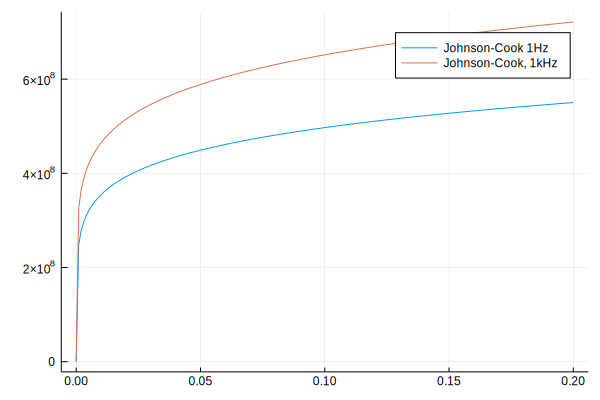

In [13]:
#For DQSK steel (automotive vehicles)

#Johnson-Cook Parameters
∂ϵ_∂t_0 = 1Hz
∂ϵ_∂t = 1Hz
T_room = 294.26K
T_m = 1808K
T_test = 300K
A = 13e6Pa
σ_y = A
B = 730e6Pa
c = 0.045
n = 0.15
h = 0.5 #This is the exponent on temperature for JohnsonCook
ϵs = 0:0.001:0.2
jcp = JohnsonCookParams(∂ϵ_∂t_0,T_room,T_m,T_test,A,B,c,n,h)
jcp_matmod = MaterialModel(E_y,σ_y,jcp)
plot(ϵs,map(ϵ -> stress(ϵ,∂ϵ_∂t,jcp_matmod)|> ustrip, ϵs),label="Johnson-Cook 1Hz")

∂ϵ_∂t = 1000Hz
jcp = JohnsonCookParams(∂ϵ_∂t_0,T_room,T_m,T_test,A,B,c,n,h)
jcp_matmod = MaterialModel(E_y,σ_y,jcp)
plot!(ϵs,map(ϵ -> stress(ϵ,∂ϵ_∂t,jcp_matmod)|> ustrip, ϵs),label="Johnson-Cook, 1kHz")